# Imports

In [6]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from src.utils.column_import import columns
from config.settings import saved_models_path

s_x, s_y, v_x, v_y, a_x, a_y = columns
 

## Load models 

In [7]:
# Load the models
def load_model(model_name):
    model_file_path = os.path.join(saved_models_path, f'acceleration_model_4/{model_name}.pkl')
    
    if os.path.exists(model_file_path):
        with open(model_file_path, 'rb') as file:
            loaded_model = pickle.load(file)
        
        print(f'Model "{model_name}" loaded from: {model_file_path}')
        return loaded_model
    else:
        print(f'Model file not found for "{model_name}"')
        print(model_file_path)
        return None

loaded_first_model = load_model('first_model')
loaded_second_model = load_model('second_model')

Model "first_model" loaded from: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/first_model.pkl
Model "second_model" loaded from: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_4/second_model.pkl


## Load the coefficients

In [8]:
# Get the coefficients
c_1_overline = loaded_first_model.coef_[0]
c_3_overline = loaded_first_model.coef_[1]
c_2_overline = loaded_second_model.coef_[0]
c_4_overline = loaded_second_model.coef_[1]

print(f'C̅₁: {c_1_overline}')
print(f'C̅₂: {c_2_overline}')
print(f'C̅₃: {c_3_overline}')
print(f'C̅₄: {c_4_overline}')

C̅₁: -0.9952219042872908
C̅₂: -0.9952386680963472
C̅₃: 0.0004375584277085994
C̅₄: 2.848228071024513e-07


Rearange the constants:
\begin{align}
c_2 =  \frac{1}{\overline c_2}
\\ c_1 = \overline c_1  \overline c_2
\\ c_4 = \frac{1}{\overline c_4}
\\ c_3 = \overline c_3 \overline c_4
\end{align}



In [9]:
# Rearange the coefficients
c_1 = c_1_overline * c_2_overline
c_2 = 1 / c_2_overline
c_3 = c_3_overline * c_4_overline
c_4 = 1 / c_4_overline

print(f'c₁: {c_1}')
print(f'c₂: {c_2}')
print(f'c₃: {c_3}')
print(f'c₄: {c_4}')

c₁: 0.9904833224831937
c₂: -1.0047841106422846
c₃: 1.2462661965129827e-10
c₄: 3510954.793870486


# Integration method

Now we put the constants into our integration model and test it on accuracy
\begin{align}
v(k+1) &= v(k) + c_1 a(k) + c_2(k-1)\\
s(k+1) &= s(k) + dt  \ v(k)+ c_3 a(k) + c_4 a(k-1)
\end{align}

We have to split each entry into its x- and y-components
\begin{align}
v_x(k+1)    &= v_x(k) + c_1 a_x(k)  +  c_2a_x(k-1)
\\ v_y(k+1) &= v_y(k) + c_1 a_y(k)  + c_2 a_y(k-1)
\\ s_x(k+1) &= s_x(k) + dt  \ v_x(k)+ c_3 a_x(k) + c_4 a_x(k-1)
\\ s_y(k+1) &= s_y(k) + dt \ v_y(k) + c_3 a_y(k) + c_4 a_y(k-1)
\end{align}




In [10]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:

In [11]:
v_x_test = v_x[1:-1] + c_1 * a_x[1:-1] + c_2 * a_x[0:-2]
v_y_test = v_y[1:-1] + c_1 * a_y[1:-1] + c_2 * a_y[0:-2]


In [12]:
dt = 0.04
s_x_test = s_x[1:-1] + dt * v_x[1:-1] + c_3 * a_x[1:-1] + c_4 * a_x[0:-2]
s_y_test = s_y[1:-1] + dt * v_y[1:-1] + c_3 * a_y[1:-1] + c_4 * a_y[0:-2]


MSE: 0.04550642911333071


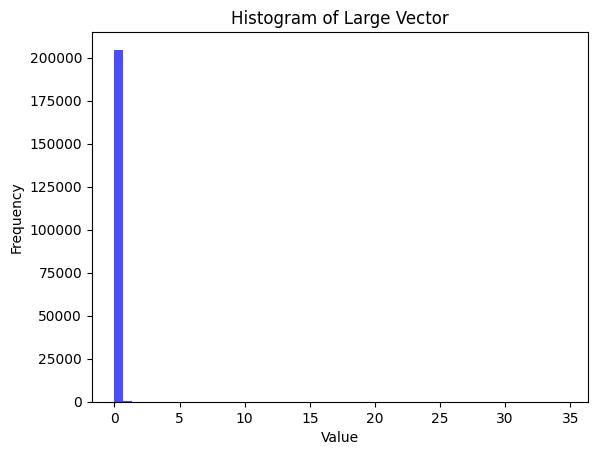

MSE: 0.03536963007831693


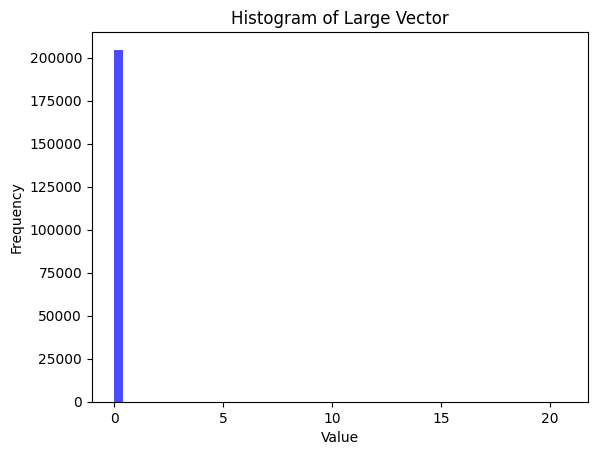

MSE: 1052493.9498954876


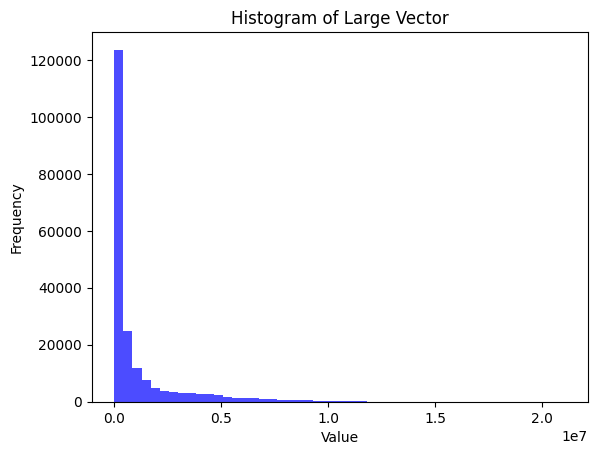

MSE: 1068187.7405820575


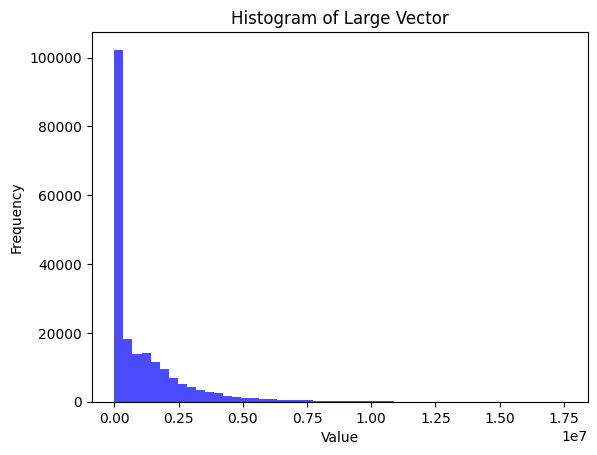

In [13]:
def mean_error(actual, test):
    difference = np.abs(actual - test)
    
    # Calculate the
    mean = np.mean(difference)
    print(f"MSE: {mean}")

    # Print a bar graph
    plt.hist(difference, bins=50, color='blue', alpha=0.7, log=False)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Large Vector')
    plt.show()

mean_error(v_x_test,v_x[2:])
mean_error(v_y_test,v_y[2:])
mean_error(s_x_test,s_x[2:])
mean_error(s_y_test,s_y[2:])


## Evaluation


In [14]:
def evaluate(y_test, y_pred):
    # Visualize the results

    plt.figure(figsize=(8, 4))
    # Evaluate the model using various metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the results in scientific notation
    print(f'Mean Squared Error (MSE): {mse:.4e}')
    print(f'Mean Absolute Error (MAE): {mae:.4e}')
    print(f'R-squared (R²) Score: {r2:.4e}')


    # Scatter plot of actual vs. predicted values with locus (line of identity)
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Locus
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0

    plt.tight_layout()
    plt.show()
 

Mean Squared Error (MSE): 4.9785e-01
Mean Absolute Error (MAE): 4.5506e-02
R-squared (R²) Score: 9.9040e-01


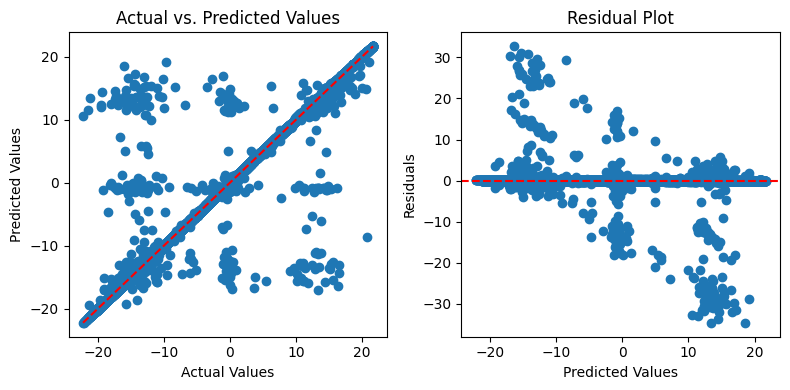

Mean Squared Error (MSE): 1.7212e-01
Mean Absolute Error (MAE): 3.5370e-02
R-squared (R²) Score: 9.8945e-01


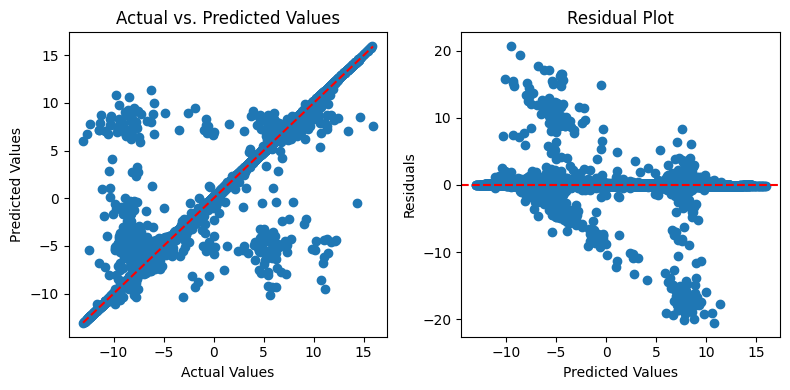

Mean Squared Error (MSE): 4.7934e+12
Mean Absolute Error (MAE): 1.0525e+06
R-squared (R²) Score: -7.8490e-02


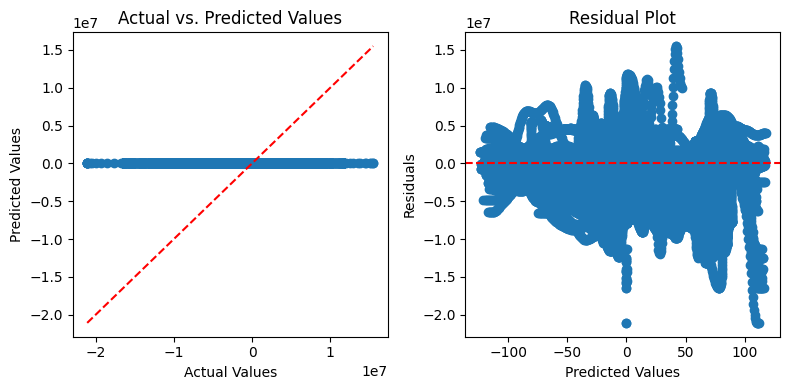

Mean Squared Error (MSE): 3.6490e+12
Mean Absolute Error (MAE): 1.0682e+06
R-squared (R²) Score: -1.9480e-02


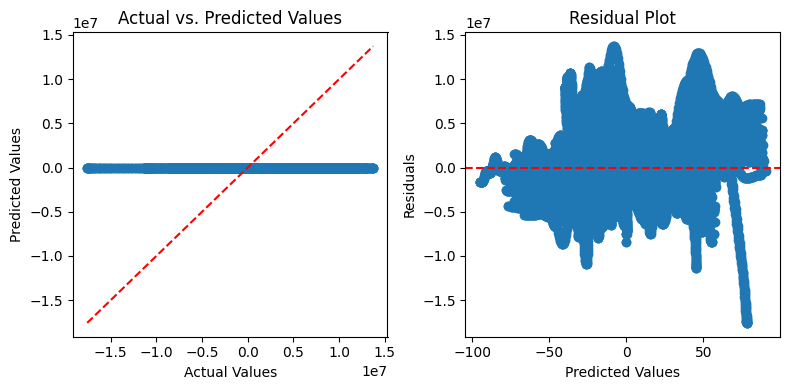

In [15]:
evaluate(s_x_test,s_x[2:])
evaluate(s_y_test,s_y[2:])
evaluate(v_x_test,v_x[2:])
evaluate(v_y_test,v_y[2:])